In [2]:
# We'll start with our library imports...
from __future__ import print_function
import pandas
import seaborn as sn
import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops
from keras.datasets import cifar100
from keras import backend as k 
import keras
from tensorflow.keras import Model
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import add, ZeroPadding2D, Add, GlobalAveragePooling2D, Dense, Activation, Flatten, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization, ReLU, Dropout, GlobalAvgPool2D, Input
from functools import partial
from keras import backend
from tensorflow.python.keras import regularizers

In [3]:
(images, labels), (temp, temp1) = cifar100.load_data()
train_images, validation_images = images[:40000], images[40000:]
train_labels, validation_labels = labels[:40000], labels[40000:]


In [4]:
img_rows, img_cols, img_width = 32, 32, 3
  
# if k.image_data_format() == 'channels_first': 
#    train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols, img_width) 
#    validation_images = validation_images.reshape(validation_images.shape[0], 1, img_rows, img_cols, img_width) 
#    inpx = (img_rows, img_cols, img_width)
  
# else: 
#    train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, img_width) 
#    validation_images = validation_images.reshape(validation_images.shape[0], img_rows, img_cols, img_width) 
#    inpx = (img_rows, img_cols, img_width) 
  
train_images = train_images.astype('float32') 
validation_images = validation_images.astype('float32') 
temp = temp.astype('float32')
train_images /= 255
validation_images /= 255
temp /= 255

In [5]:
train_labels = keras.utils.to_categorical(train_labels)
print(train_labels.shape)
validation_labels_save = validation_labels
validation_labels = keras.utils.to_categorical(validation_labels)
temp1 = keras.utils.to_categorical(temp1)

(40000, 100)


In [6]:
input_shape = (img_rows, img_cols, img_width)

In [7]:
EXPANSION_FACTOR = 4
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)
class Bottleneck(keras.layers.Layer):
    
    def __init__(self, filter_num, stride=1):
        super(Bottleneck, self).__init__()
        self.stride = stride
        assert filter_num % EXPANSION_FACTOR == 0
        
        self.conv1 = Conv2D(filter_num // EXPANSION_FACTOR, kernel_size=1, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(filter_num // EXPANSION_FACTOR, kernel_size=3, strides=stride, padding='same')
        self.bn2 = BatchNormalization()
        self.conv3 = Conv2D(filter_num, kernel_size=1, padding='same')
        self.bn3 = BatchNormalization()
        self.dropout = Dropout(rate=0.25)
        if self.stride != 1:
            self.down_conv = tf.keras.layers.Conv2D(filters=filter_num,
                                                    kernel_size=(1, 1),
                                                    strides=stride,
                                                    padding="same")
            self.down_bn = tf.keras.layers.BatchNormalization()

    def __call__(self, x, is_training = True):
        identity = x
        if self.stride != 1:
            identity = self.down_conv(identity)
            identity = self.down_bn(identity, training=is_training)

        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        x = self.conv1(x)

        x = self.bn2(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)

        x = self.bn3(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        x = self.conv3(x)

        return x + identity

In [8]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
input_shape=input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(Bottleneck(filters, stride=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 8, 8, 64)]        0         
_________________________________________________________________
dropout (Dropout)            multiple                  0

In [9]:
# using Sequential groups all the layers to run at once

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 30)
history = model.fit(train_images, train_labels, batch_size = 32, epochs=500, validation_data=(validation_images, validation_labels), callbacks = [es], shuffle=True, use_multiprocessing=(True))

Epoch 1/500
1250/1250 [==============================] - 78s 63ms/step - loss: 5.0273 - accuracy: 0.0239 - val_loss: 4.2436 - val_accuracy: 0.0586
Epoch 2/500
1250/1250 [==============================] - 39s 32ms/step - loss: 4.3793 - accuracy: 0.0483 - val_loss: 3.9851 - val_accuracy: 0.0895
Epoch 3/500
1250/1250 [==============================] - 39s 32ms/step - loss: 4.0861 - accuracy: 0.0763 - val_loss: 3.7608 - val_accuracy: 0.1247
Epoch 4/500
1250/1250 [==============================] - 39s 32ms/step - loss: 3.8951 - accuracy: 0.1016 - val_loss: 3.6717 - val_accuracy: 0.1339
Epoch 5/500
1250/1250 [==============================] - 39s 32ms/step - loss: 3.7561 - accuracy: 0.1228 - val_loss: 3.5353 - val_accuracy: 0.1632
Epoch 6/500
1250/1250 [==============================] - 39s 32ms/step - loss: 3.6485 - accuracy: 0.1408 - val_loss: 3.4180 - val_accuracy: 0.1814
Epoch 7/500
1250/1250 [==============================] - 39s 32ms/step - loss: 3.5460 - accuracy: 0.1595 - val_loss: 3

In [10]:
validation_evaluation = model.evaluate(validation_images, validation_labels)


313/313 [==============================] - 2s 6ms/step - loss: 2.2410 - accuracy: 0.4460


In [11]:
model.evaluate(temp, temp1)

313/313 [==============================] - 2s 6ms/step - loss: 2.2023 - accuracy: 0.4556


[2.2022705078125, 0.45559999346733093]

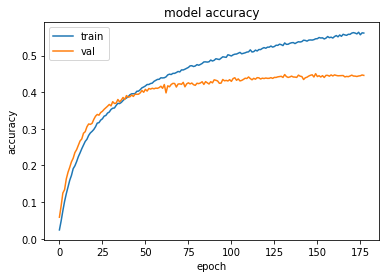

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

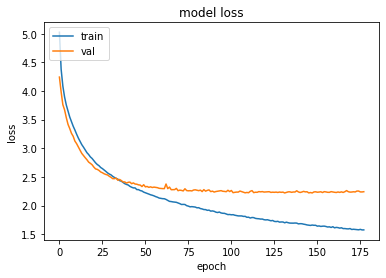

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
y_predict = model.predict(validation_images)

In [15]:
y_prediction_bin = np.array([])

for example in y_predict:
    maxN = example[0]
    ind = 0
    for i in range(1, 100):
        if example[i] > maxN:
            ind = i
            maxN = example[i]
    y_prediction_bin = np.append(y_prediction_bin, ind)

y_prediction_bin = y_prediction_bin.astype(int)
print(y_prediction_bin) 

[76 26  2 ... 88  6 73]


In [16]:
confusion_matrix = tf.math.confusion_matrix(validation_labels_save, y_prediction_bin)
print(confusion_matrix)

tf.Tensor(
[[65  0  1 ...  0  0  0]
 [ 0 68  0 ...  0  0  0]
 [ 0  1 42 ...  1  4  0]
 ...
 [ 0  0  2 ... 55  0  0]
 [ 0  0 14 ...  1 25  0]
 [ 1  0  0 ...  0  1 26]], shape=(100, 100), dtype=int32)


In [17]:
np.savetxt("HW1_model2_confusion_matrix.txt", confusion_matrix.numpy(), fmt='%03.d')

In [18]:
from math import sqrt
validation_data_error = 1 - validation_evaluation[1]

lower_bound_interval = validation_data_error - 1.96 * sqrt( (validation_data_error * (1 - validation_data_error)) / len(validation_labels))
upper_bound_interval = validation_data_error + 1.96 * sqrt( (validation_data_error * (1 - validation_data_error)) / len(validation_labels))

print("The 95% Confidence interval for error hypothesis based on the normal distribution estimator: ", (lower_bound_interval, upper_bound_interval))

The 95% Confidence interval for error hypothesis based on the normal distribution estimator:  (0.5442573114430266, 0.5637426690066499)


In [ ]:
L2_WEIGHT_DECAY = 0.2
BATCH_NORM_DECAY = 0.99
BATCH_NORM_EPSILON = 0.001

In [ ]:
def identity_block(input_tensor, kernel_size, filters):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x =  Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)

    x =  BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x =  Activation('relu')(x)

    x =  Conv2D(filters2, kernel_size,
                      padding='same', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    x =  BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    x =  Activation('relu')(x)

    x =  Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    x =  BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    x =  add([x, input_tensor])
    x =  Activation('relu')(x)
    return x

In [ ]:
def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the second conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """

    filters1, filters2, filters3 = filters

    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x =  Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)
    x =  BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x =  Activation('relu')(x)


    x =  Conv2D(filters2, kernel_size, strides=strides, padding='same',
                      use_bias=False, kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
    x =  BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x =  Activation('relu')(x)

    x =  Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
    x =  BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    shortcut =  Conv2D(filters3, (1, 1), strides=strides, use_bias=False,
                             kernel_initializer='he_normal',
                             kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)
    shortcut =  BatchNormalization(axis=bn_axis,
                                         momentum=BATCH_NORM_DECAY,
                                         epsilon=BATCH_NORM_EPSILON)(shortcut)

    x =  add([x, shortcut])
    x =  Activation('relu')(x)
    return x

In [ ]:
def resnet50(num_classes, input_shape):
    img_input = Input(shape=input_shape)
    
    if backend.image_data_format() == 'channels_first':
        x = Lambda(lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),
                          name='transpose')(img_input)
        bn_axis = 1
    else:  # channels_last
        x = img_input
        bn_axis = 3

    # Conv1 (7x7,64,stride=2)
    x = ZeroPadding2D(padding=(3, 3))(x)

    x = Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
    x = BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)

    # 3x3 max pool,stride=2
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Conv2_x

    # 1×1, 64
    # 3×3, 64
    # 1×1, 256

    x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])

    # Conv3_x
    #
    # 1×1, 128
    # 3×3, 128
    # 1×1, 512

    x = conv_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])

    # Conv4_x
    # 1×1, 256
    # 3×3, 256
    # 1×1, 1024
    #x = conv_block(x, 3, [256, 256, 1024])
    #x = identity_block(x, 3, [256, 256, 1024])
    #x = identity_block(x, 3, [256, 256, 1024])
    #x = identity_block(x, 3, [256, 256, 1024])
    #x = identity_block(x, 3, [256, 256, 1024])
    #x = identity_block(x, 3, [256, 256, 1024])

    # 1×1, 512
    # 3×3, 512
    # 1×1, 2048
    #x = conv_block(x, 3, [512, 512, 2048])
    #x = identity_block(x, 3, [512, 512, 2048])
    #x = identity_block(x, 3, [512, 512, 2048])
    
    # average pool, 100-d fc, softmax
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        num_classes, activation='softmax',
        kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY),
        bias_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    # Create model.
    return Model(img_input, x)

In [ ]:
model = resnet50(100, input_shape)
model.summary()

In [ ]:
# using Sequential groups all the layers to run at once

optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 30)
history = model.fit(train_images, train_labels, batch_size = 32, epochs=400, validation_data=(validation_images, validation_labels), callbacks = [es], shuffle=True, use_multiprocessing=(True))

In [ ]:
tf.saved_model.save(model, 'homework1/cifar100')